<a href="https://colab.research.google.com/github/orhanaydinn/brainTumor_Alzheimer_Prediction/blob/main/BrainTumor_Alzheimer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 - Uploaded Dataset**

tumor_alzheimer_dataset.zip file upload manually.
```
zip_path = "/content/brain_disease_classification_dataset.zip"
extract_path = "/content/brain_disease_classification_dataset"
```
**zip_path** represents the file path of the uploaded ZIP file.

**extract_path** defines the destination directory where the contents of the ZIP file will be extracted.

In [1]:
import zipfile
import os

# File and directory paths to extract
zip_path = "/content/brain_disease_classification_dataset.zip"
extract_path = "/content/brain_disease_classification_dataset"

# Open zip file and extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset successfully extracted to:", extract_path)


Dataset successfully extracted to: /content/brain_disease_classification_dataset


Check the loaded datasets before data preparation process.

**`os.walk(extract_path)`** Examines the entire structure of the specified folder, including its subfolders.

**`root`** The full path of the currently browsed directory.

**`dirs`** list of folders in that directory.

**`files`** list of files in that directory.



In [2]:
for root, dirs, files in os.walk(extract_path):
    print(f"\n{root}")
    for d in dirs:
        print(f"├── {d}")
    for f in files[:5]:
        print(f"├── {f}")


/content/brain_disease_classification_dataset
├── alzheimer
├── tumor

/content/brain_disease_classification_dataset/alzheimer
├── alzheimer_non_demented
├── alzheimer_moderate_demented
├── alzheimer_mild_demented
├── alzheimer_very_mild_demented

/content/brain_disease_classification_dataset/alzheimer/alzheimer_non_demented
├── non_demented_2433.jpg
├── non_demented_8085.jpg
├── non_demented_4641.jpg
├── non_demented_12683.jpg
├── non_demented_8421.jpg

/content/brain_disease_classification_dataset/alzheimer/alzheimer_moderate_demented
├── moderate_4266.jpg
├── moderate_4559.jpg
├── moderate_1559.jpg
├── moderate_2295.jpg
├── moderate_1008.jpg

/content/brain_disease_classification_dataset/alzheimer/alzheimer_mild_demented
├── mild_6323.jpg
├── mild_6644.jpg
├── mild_9120.jpg
├── mild_7888.jpg
├── mild_3575.jpg

/content/brain_disease_classification_dataset/alzheimer/alzheimer_very_mild_demented
├── very_mild_5271.jpg
├── very_mild_7845.jpg
├── very_mild_3279.jpg
├── very_mild_4908.j

**` def show_random_images(dataset_dir, samples=3):`**
This function displays a random 3 sample images from each class.

**`img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`**
cv2 library create BGR images default setting. This code convert BGR to RGB.



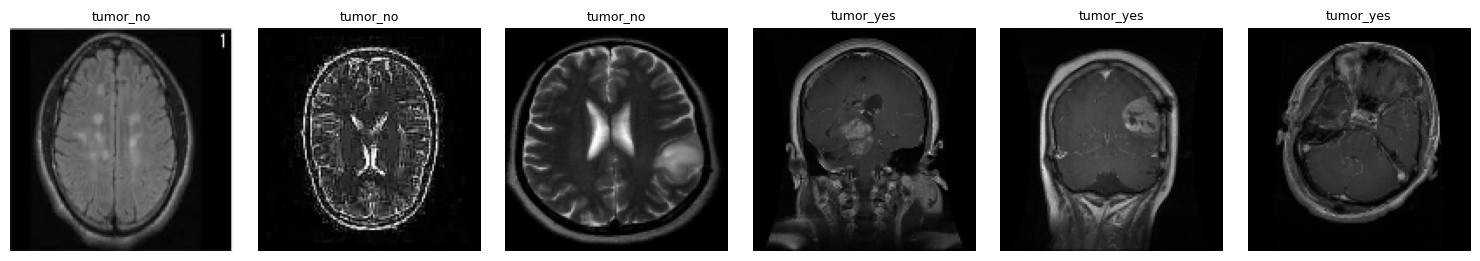

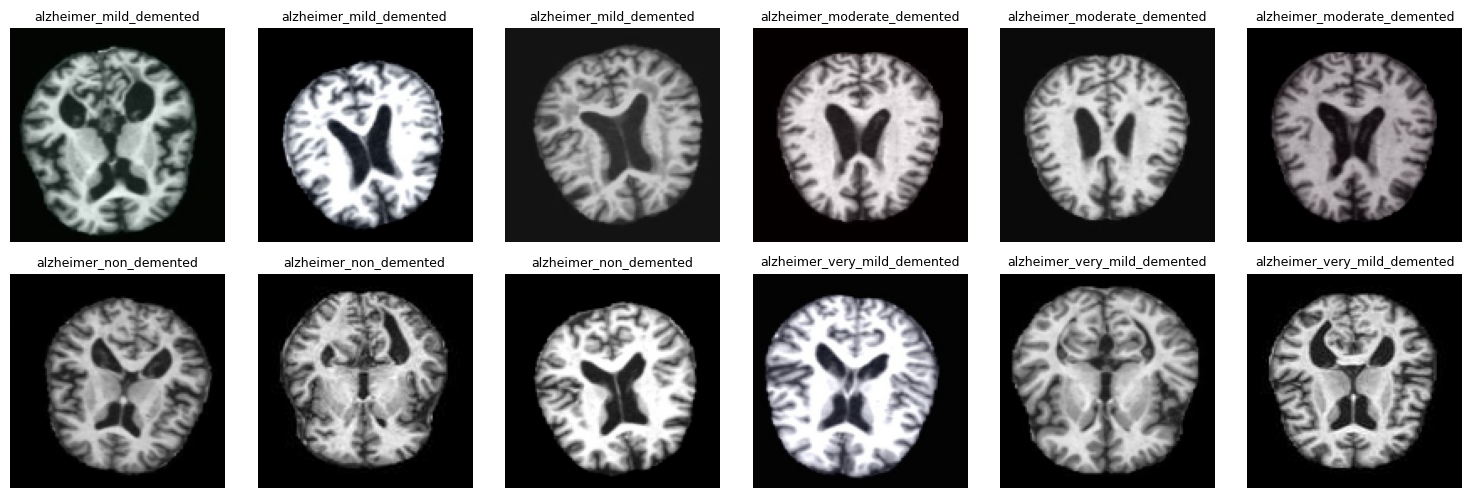

In [18]:
import os
import cv2
import random
import matplotlib.pyplot as plt

IMG_SIZE = 128

def show_random_images(dataset_dir, samples=3):
    class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

    rows = len(class_folders)
    cols = 6
    plt.figure(figsize=(cols * 2.5, rows * 2.5))
    i = 1
    for label in sorted(class_folders):
        class_path = os.path.join(dataset_dir, label)
        images = os.listdir(class_path)
        random.shuffle(images)

        for img_name in images[:samples]:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            plt.subplot(rows, cols, i)
            plt.imshow(img)
            plt.title(label, fontsize=9)
            plt.axis('off')
            i += 1
    plt.tight_layout()
    plt.show()


# Tümör
show_random_images("/content/brain_disease_classification_dataset/tumor")

# Alzheimer
show_random_images("/content/brain_disease_classification_dataset/alzheimer")


Check the dataset size before pre processing.

                              Tumor  Alzheimer
tumor_no                       3598          0
tumor_yes                      6679          0
alzheimer_mild_demented           0       9856
alzheimer_moderate_demented       0       6528
alzheimer_non_demented            0      12800
alzheimer_very_mild_demented      0      11200


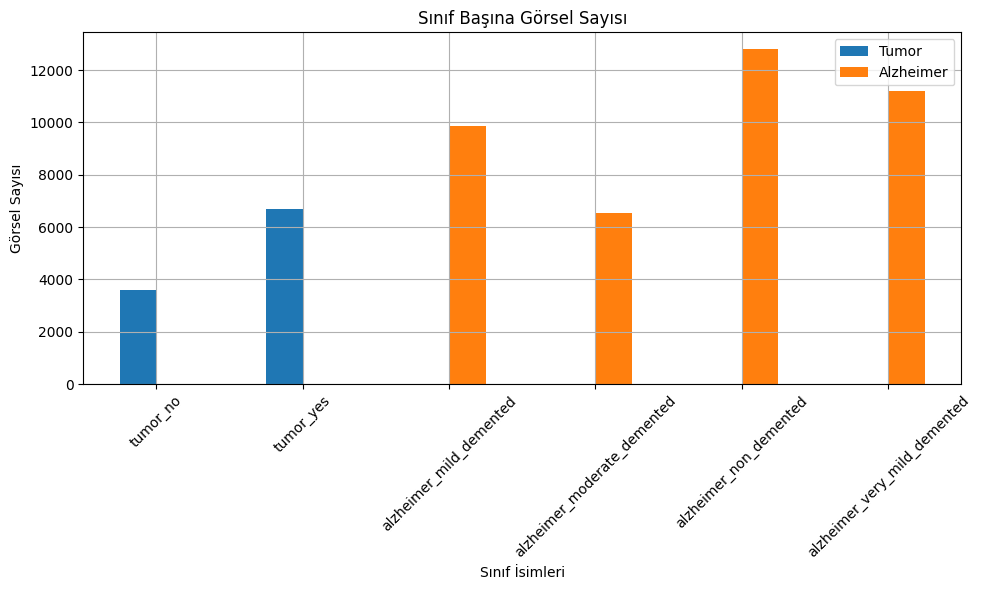

In [13]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Klasör yolları (kendi ortamına göre güncelle)
tumor_dir = "/content/brain_disease_classification_dataset/tumor"
alz_dir = "/content/brain_disease_classification_dataset/alzheimer"

# Sınıf sayısını hesaplayan fonksiyon
def count_images_in_folders(base_dir):
    class_counts = {}
    for class_name in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    return class_counts

# Veri sayısı
tumor_counts = count_images_in_folders(tumor_dir)
alz_counts = count_images_in_folders(alz_dir)

# Veriyi DataFrame'e çevir
tumor_df = pd.DataFrame.from_dict(tumor_counts, orient='index', columns=['Tumor'])
alz_df = pd.DataFrame.from_dict(alz_counts, orient='index', columns=['Alzheimer'])

# Birleştir
df_counts = pd.concat([tumor_df, alz_df], axis=0).fillna(0).astype(int)
print(df_counts)

# Bar grafiği çiz
df_counts.plot(kind="bar", figsize=(10, 6), legend=True)
plt.title("Sınıf Başına Görsel Sayısı")
plt.ylabel("Görsel Sayısı")
plt.xlabel("Sınıf İsimleri")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# **2 - Tumor Data Preparation & Preprocessing**

In this section, the data was examined and augmentation was applied to some labels.

*   Load and Label Data
*   Read, Resize and Convert Images to Arrays
*   Convert to Numpy Arrays and Normalize the Pixel Values
*   Data Augmentation
    *   Class Distribution Table
    *   Augmentation for **tumor_no** labels
        *   Show Augmentation Images
*   Shor Current Dataset




## 2.1 - Load and Label Data

**`label_map = {label: idx for idx, label in enumerate(class_names)}`**

This code automatically detects the class folders in the dataset directory and maps each class to a unique integer.

In [14]:
import os


DATASET_DIR = "/content/brain_disease_classification_dataset/tumor"

# Sınıf isimlerini al ve etiketle
class_names = sorted(os.listdir(DATASET_DIR))
label_map = {label: idx for idx, label in enumerate(class_names)}
print("Label Mapping:", label_map)

Label Mapping: {'tumor_no': 0, 'tumor_yes': 1}


## 2.2 - Read, Resize and Convert Images to Arrays

In this project image size is used 64x64 (`IMG_SIZE = 64`) . Therefore, this code `img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))` resize all of images which are differents size.

In [15]:
import os
import cv2
import numpy as np


DATASET_DIR = "/content/brain_disease_classification_dataset/tumor"
IMG_SIZE = 64

class_names = sorted(os.listdir(DATASET_DIR))
label_map = {label: idx for idx, label in enumerate(class_names)}


X = []
y = []

for label in class_names:
    class_path = os.path.join(DATASET_DIR, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            X.append(img)
            y.append(label_map[label])



## 2.3 - Convert to NumPy Arrays & Normalize the Pixel Values

This code block makes the data types available for model training and normalizes the pixel values ​​of the images.

```
X = np.array(X, dtype='float32')
y = np.array(y)
```
Converts the Python lists X and y into NumPy arrays.

`X /= 255.0` It reduces the pixel values ​​from the range of 0-255 to the range of 0-1. This process allows the model to learn faster and more stably.

In [16]:
X = np.array(X, dtype=np.float32)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (10277, 64, 64, 3)
y shape: (10277,)


## 2.4 - Data Augmentation

### 2.4.1 -  Class Distribution Table

Before the data augmentation, dataset was controlled anc created table which are include label, label name, image count.

In [17]:
import pandas as pd
from collections import Counter


label_counts = Counter(y)
reverse_label_map = {v: k for k, v in label_map.items()}


class_distribution_df = pd.DataFrame({
    'Label Index': list(label_counts.keys()),
    'Label Name': [reverse_label_map[i] for i in label_counts.keys()],
    'Image Count': list(label_counts.values())
})


class_distribution_df = class_distribution_df.sort_values(by='Image Count', ascending=False)
display(class_distribution_df)


,Label Index,Label Name,Image Count
1,1,tumor_yes,6679
0,0,tumor_no,3598


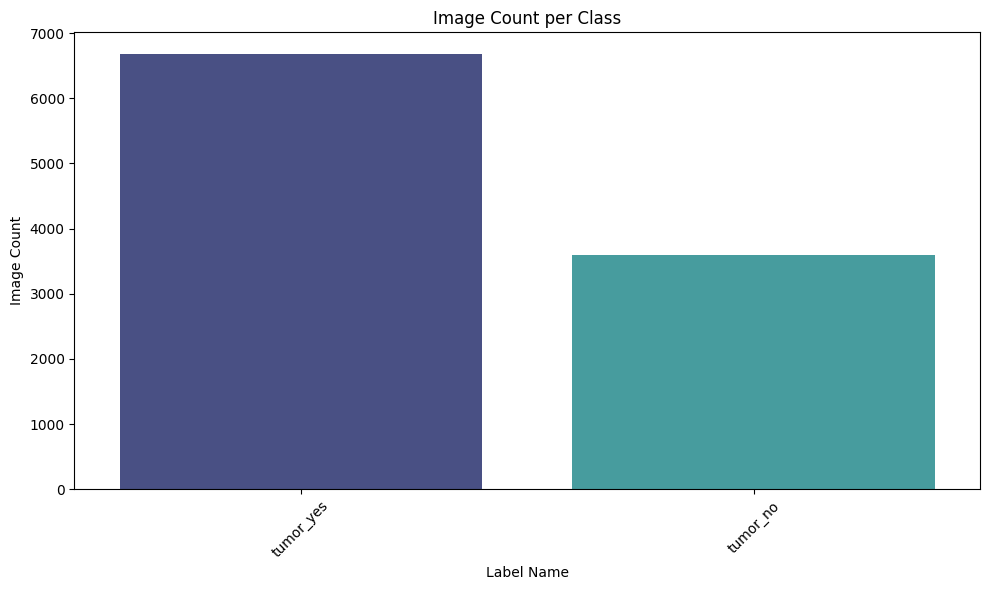

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 6))
sns.barplot(data=class_distribution_df, x="Label Name", y="Image Count", palette="mako")
plt.title("Image Count per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This dataset has enough images for classification problem **alzheimer**. However, the **tumor_yes** and **tumor_no** classes have significantly fewer samples compared to the others, which can lead to class unbalance and potential overfitting issues. Therefore augmention was applied just two labels.

### 2.4.2 - Tumor_NO Augmentation

`target_count = 6000` The target number of images was determined as 6000 and the current number of images was subtracted from this number `to_generate = target_count - current_count`.

`for img_name in tqdm(existing_images):` This function generated the required number of images.

```
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
```


*   Every images was rotated 15°. `rotation_range=15`
*   Zoomed by 10% `zoom_range=0.1`.
*   Slightly shifted horizontally and vertically `width_shift_range=0.1,
height_shift_range=0.1`.
*   Brightness was adjusted between 80% and 120%. `brightness_range=[0.8,1.2]`
*   Some images were flipped horizontally. Empty areas were filled using the nearest pixel method. `horizontal_flip=True, fill_mode='nearest'`


` aug_name = f"aug_tumor_no_{image_idx}.jpg"` This code adds the names **aug_tumor_no_1, aug_tumor_no_2, ..... , aug_tumor_no_n** to the new images

In [20]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Settings
target_count = 6000
input_folder = "/content/brain_disease_classification_dataset/tumor/tumor_no"
IMG_SIZE = 64


existing_images = os.listdir(input_folder)
current_count = len(existing_images)
to_generate = target_count - current_count

print(f"📁 Current: {current_count} — Target: {target_count} — Generating: {to_generate}")


image_idx = 1
for img_name in tqdm(existing_images):
    img_path = os.path.join(input_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.reshape((1, IMG_SIZE, IMG_SIZE, 3))

    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(2):  # Generate 2 images from all images
        if image_idx > to_generate:
            break
        aug_img = next(aug_iter)[0].astype(np.uint8)
        aug_name = f"aug_tumor_no_{image_idx}.jpg"
        cv2.imwrite(os.path.join(input_folder, aug_name), aug_img)
        image_idx += 1

print("The augmentation process is complete.")


📁 Current: 3598 — Target: 6000 — Generating: 2402


100%|██████████| 3598/3598 [00:04<00:00, 735.19it/s] 

The augmentation process is complete.


#### 2.4.2.1 - Show Augmentation Images

Check new augmentation 15 images randomly. `sample_imgs = random.sample(aug_images, min(15, len(aug_images)))`

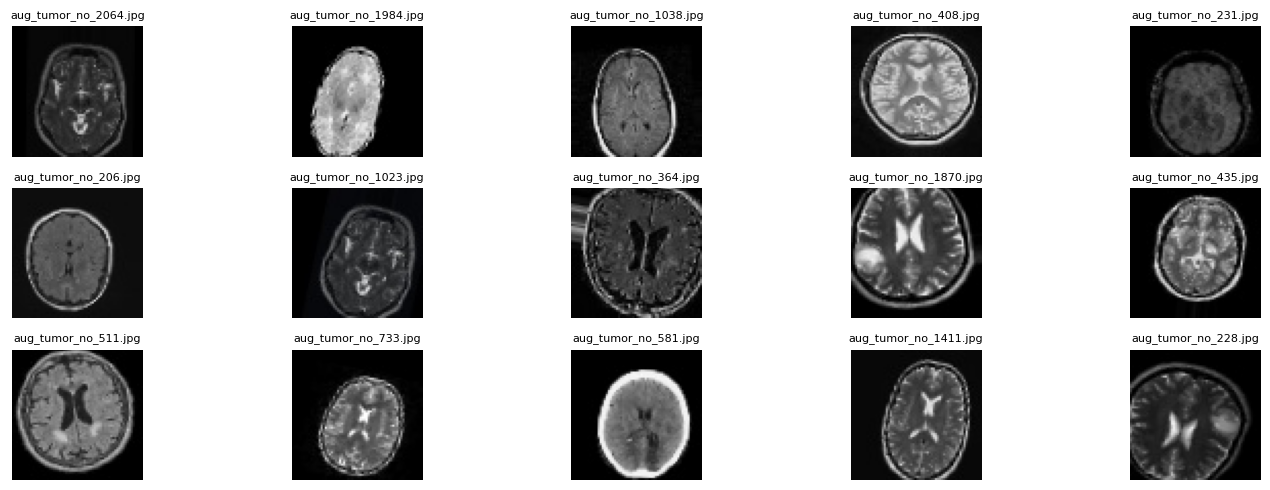

In [21]:
import matplotlib.pyplot as plt
import cv2
import os
import random


augmented_folder = "/content/brain_disease_classification_dataset/tumor/tumor_no"


aug_images = [img for img in os.listdir(augmented_folder) if img.startswith("aug_")]

# Show random 15 images for augmentation
sample_imgs = random.sample(aug_images, min(15, len(aug_images)))


plt.figure(figsize=(15, 5))
for idx, img_name in enumerate(sample_imgs):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


## 2.5 - Show Current Dataset

After the data augmentation, dataset was controlled and created table which are class and image count.

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset path
DATASET_DIR = "/content/brain_disease_classification_dataset/tumor"


class_names = sorted([folder for folder in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, folder))])

# Count images
class_counts = {cls: len([img for img in os.listdir(os.path.join(DATASET_DIR, cls))
                          if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
                for cls in class_names}

# crate Dataframe
df_distribution = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
df_distribution = df_distribution.sort_values("Image Count", ascending=False)

# show table
df_distribution.reset_index(drop=True, inplace=True)
df_distribution


,Class,Image Count
0,tumor_yes,6679
1,tumor_no,6000


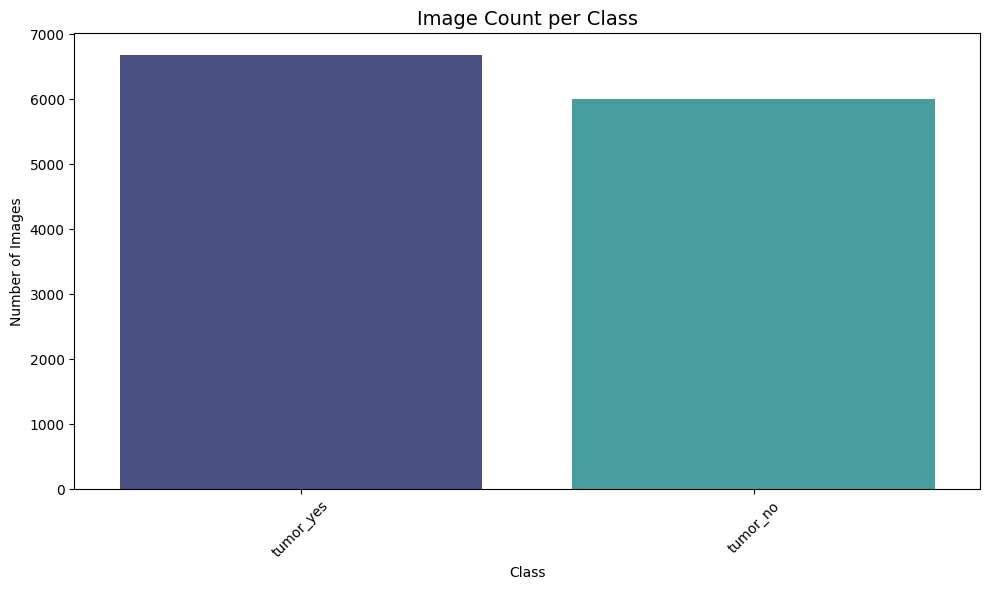

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_distribution, x="Class", y="Image Count", palette="mako")
plt.title("Image Count per Class", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# **3 - Tumor Model Training & Evaluation**

In this section, CNN and ML models are created and compared for **tumor dataset**.

*   Split Data ( Train / Test )
*   CNN Model
*   CNN Model Training
    *   Training Visualization
    *   Confusion Matrix
*   VGG16 - Transfer Learning Model
*   VGG16 - Transfer Learning Model Training



## 3.1 - Split the Data (Train / Test)

The train and test datasets are separated by 20%.

In [24]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (8221, 64, 64, 3)
Test Set Shape: (2056, 64, 64, 3)


## 3.2 - CNN Model

Base cnn was created for first cnn model.


**CNN - Model Architecture**

```
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
```


*   `Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3))` Aconvolutional layer with 32 filters of size 3x3 and ReLU activation.
*   `Conv2D(64, (3, 3), activation='relu')` Reduces spatial dimensions.

*   `Flatten()` Converts the 2D feature maps into a 1D vector for dense layers.

*    `Dense(128, activation='relu'),` A fully connected layer with 128 units and ReLU activation.

*     `Dropout(0.5)` Drops 50% of the neurons to prevent overfitting.

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # output layer
])



**CNN - Model Compilation**

```
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
```

*   `optimizer='adam'` In this project the Adam optimization algorithm was preferred. Adam automatically adapts the learning rate for each parameter separately using first and second moment estimates. This leads to faster and more stable convergence during training.


In [32]:
# Compile
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # << Doğru olan bu
    metrics=['accuracy']
)


**CNN - EarlyStopping**
```
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
```
Stops training if validation accuracy does not improve for 5 consecutive epochs. Recovers the best weights.


In [33]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**CNN - Model Checkpoint**

```
model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
```
Saves the model file with the best validation accuracy. The best validation accuracy was saved "**best_cnn_model.h5**" in this cnn model. This checkpoint will be used directly in the later stages of the project. There is no need to retrain the model each time it is run from the beginning.


In [34]:
# Checkpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [35]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3 CNN Model Training

**CNN - Time Calculation**

```
import time
start = time.time()


end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

```
Starts a timer to measure how long model training takes. After the training, stops the timer and prints total training time in seconds.


**CNN - Model Training**
```
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)
```



*   `X_train, y_train,` Trains the CNN model using the training data.
*   `epochs=30, batch_size=32` Training was run for 30 epochs, and process 32 images at a time (batch size).
*   `callbacks=[early_stop,` This code can stops training if validation loss doesn’t improve for a few epochs.
*   `callbacks=[  ,model_checkpoint]` Saves the model with the best validation accuracy.
*   `verbose=1` Prints progress of training for each epoch.

In [36]:
import time
start = time.time()

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7618 - loss: 0.5080
Epoch 1: val_accuracy improved from -inf to 0.90370, saving model to best_cnn_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 31s 114ms/step - accuracy: 0.7621 - loss: 0.5075 - val_accuracy: 0.9037 - val_loss: 0.2331
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9068 - loss: 0.2232
Epoch 2: val_accuracy improved from 0.90370 to 0.95282, saving model to best_cnn_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.9069 - loss: 0.2231 - val_accuracy: 0.9528 - val_loss: 0.1377
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9553 - loss: 0.1196
Epoch 3: val_accuracy improved from 0.95282 to 0.95331, saving model to best_cnn_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.9553 - loss: 0.1195 - val_accuracy: 0.9533 - val_loss: 0.1273
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9779 - loss: 0.0759
Epoch 4: val_accuracy improved from 0.95331 to 0.97811, saving model to best_cnn_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.9779 - loss: 0.0759 - val_accuracy: 0.9781 - val_loss: 0.0772
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9849 - loss: 0.0483
Epoch 5: val_accuracy improved from 0.97811 to 0.98735, saving model to best_cnn_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.9849 - loss: 0.0483 - val_accuracy: 0.9874 - val_loss: 0.0651
Epoch 6/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9912 - loss: 0.0267
Epoch 6: val_accuracy did not improve from 0.98735
257/257 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.9912 - loss: 0.0267 - val_accuracy: 0.9874 - val_loss: 0.0626
Epoch 7/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9924 - loss: 0.0232
Epoch 7: val_accuracy did not improve from 0.98735
257/257 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - accuracy: 0.9924 - loss: 0.0232 - val_accuracy: 0.9864 - val_loss: 0.0602
Epoch 8/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9954 - loss: 0.0168
Epoch 8: val_accuracy did not improve from 0.98735
257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9954 - loss: 0.0168 - val_accuracy: 0.9874 - val_loss: 0.0549
Epoch 9/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9966 - loss: 0.0122
Epoch 9: val_ac

257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.9966 - loss: 0.0122 - val_accuracy: 0.9883 - val_loss: 0.0731
Epoch 10/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9931 - loss: 0.0182
Epoch 10: val_accuracy improved from 0.98833 to 0.98979, saving model to best_cnn_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.9931 - loss: 0.0182 - val_accuracy: 0.9898 - val_loss: 0.0658
Epoch 11/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9992 - loss: 0.0045
Epoch 11: val_accuracy improved from 0.98979 to 0.99076, saving model to best_cnn_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.9992 - loss: 0.0045 - val_accuracy: 0.9908 - val_loss: 0.0669
Epoch 12/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9981 - loss: 0.0078
Epoch 12: val_accuracy did not improve from 0.99076
257/257 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.9981 - loss: 0.0078 - val_accuracy: 0.9898 - val_loss: 0.0892
Epoch 13/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9961 - loss: 0.0125
Epoch 13: val_accuracy did not improve from 0.99076
257/257 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.9961 - loss: 0.0125 - val_accuracy: 0.9878 - val_loss: 0.0792
Epoch 14/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9970 - loss: 0.0086
Epoch 14: val_accuracy did not improve from 0.99076
257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9970 - loss: 0.0085 - val_accuracy: 0.9898 - val_loss: 0.0888
Epoch 15/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9995 - loss: 0.0024
Epoch 15

257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9952 - loss: 0.0121 - val_accuracy: 0.9917 - val_loss: 0.0759
Epoch 17/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9976 - loss: 0.0062
Epoch 17: val_accuracy did not improve from 0.99173
257/257 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.9976 - loss: 0.0062 - val_accuracy: 0.9898 - val_loss: 0.0911
Epoch 18/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9994 - loss: 0.0029
Epoch 18: val_accuracy improved from 0.99173 to 0.99222, saving model to best_cnn_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 114ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9922 - val_loss: 0.0865
Epoch 19/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9976 - loss: 0.0091
Epoch 19: val_accuracy did not improve from 0.99222
257/257 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - accuracy: 0.9976 - loss: 0.0091 - val_accuracy: 0.9893 - val_loss: 0.0869
Epoch 20/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9953 - loss: 0.0149
Epoch 20: val_accuracy did not improve from 0.99222
257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9953 - loss: 0.0149 - val_accuracy: 0.9908 - val_loss: 0.0953
Epoch 21/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9954 - loss: 0.0136
Epoch 21: val_accuracy did not improve from 0.99222
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 114ms/step - accuracy: 0.9955 - loss: 0.0136 - val_accuracy: 0.9883 - val_loss: 0.1014
Epoch 22/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9984 - loss: 0.0065
Epoch 22

**CNN Model Training Summary**

The model completed its learning in approximately 15 minutes. It completed the learning process in the 23rd epoch and achieved the best result in the 18th epoch.

### 3.3.1 CNN Model Training Visualization

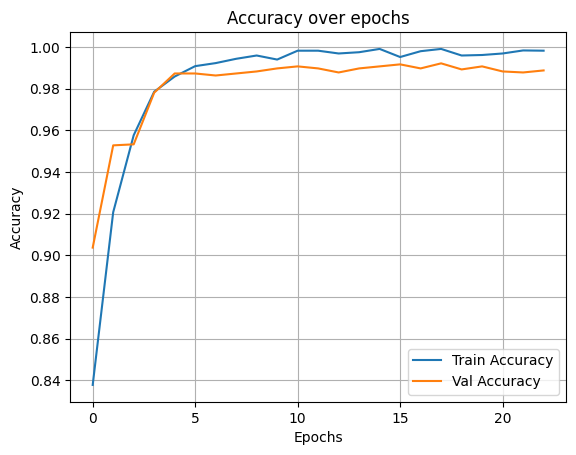

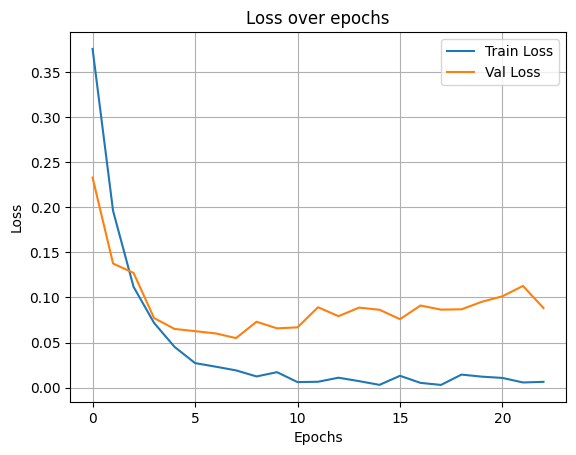

In [37]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 3.3.2 Confusion Matrix for CNN Model

Confusion matrix was used for estimation calculation.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_cnn_model.h5")

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step


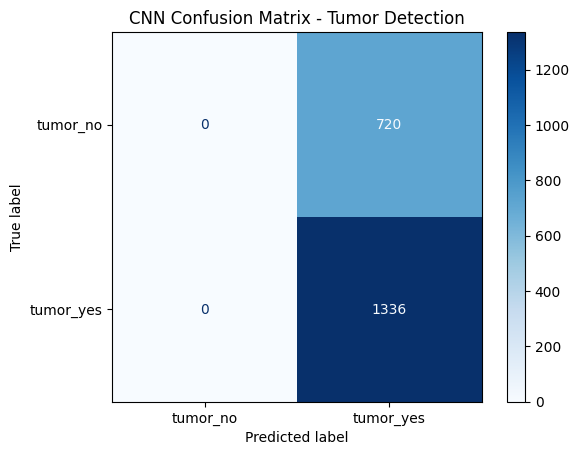

CNN Classification Report:

              precision    recall  f1-score   support

    tumor_no       0.00      0.00      0.00       720
   tumor_yes       0.65      1.00      0.79      1336

    accuracy                           0.65      2056
   macro avg       0.32      0.50      0.39      2056
weighted avg       0.42      0.65      0.51      2056



In [72]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("CNN Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("CNN Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))


## 3.4 - VGG16 - Transfer Learning Model

VGG16 Transfer Learning was created for another deep learning model.

**VGG16 - Model Architecture**
*   `base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))` Loads the VGG16 model pre-trained on ImageNet without the top layer. The input shape is set to 64x64 RGB images.


In [43]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add last layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


model_vgg16 = Model(inputs=base_model.input, outputs=x)


for layer in base_model.layers:
    layer.trainable = False


**VGG16 - Model Compilation**

In [44]:
# Compile
model_vgg16.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

**VGG16 - Earlystop**

In [45]:
# Earlystop
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**VGG16 - Model Checkpoint**

Saves the model file with the best validation accuracy. The best validation accuracy was saved "**best_vgg16_model.h5**" in this vgg16 model.

In [46]:
# Model Checkpoint
model_checkpoint = ModelCheckpoint(
    'best_vgg16_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [47]:
model_vgg16.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 3.5 - VGG16 - Transfer Learning Model Training

**Model Training - Time Calculation**

In [48]:
import time
start = time.time()

history_vgg16 = model_vgg16.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.7276 - loss: 0.5146
Epoch 1: val_accuracy improved from -inf to 0.86673, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.7278 - loss: 0.5144 - val_accuracy: 0.8667 - val_loss: 0.3213
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.8553 - loss: 0.3307
Epoch 2: val_accuracy improved from 0.86673 to 0.90224, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.8554 - loss: 0.3307 - val_accuracy: 0.9022 - val_loss: 0.2481
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.8919 - loss: 0.2658
Epoch 3: val_accuracy improved from 0.90224 to 0.92072, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.8919 - loss: 0.2658 - val_accuracy: 0.9207 - val_loss: 0.2091
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9078 - loss: 0.2326
Epoch 4: val_accuracy improved from 0.92072 to 0.92802, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.9078 - loss: 0.2325 - val_accuracy: 0.9280 - val_loss: 0.1848
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9186 - loss: 0.2044
Epoch 5: val_accuracy improved from 0.92802 to 0.94650, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.9186 - loss: 0.2044 - val_accuracy: 0.9465 - val_loss: 0.1593
Epoch 6/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9286 - loss: 0.1913
Epoch 6: val_accuracy did not improve from 0.94650
257/257 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.9286 - loss: 0.1913 - val_accuracy: 0.9363 - val_loss: 0.1574
Epoch 7/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.9294 - loss: 0.1772
Epoch 7: val_accuracy improved from 0.94650 to 0.95185, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.9294 - loss: 0.1772 - val_accuracy: 0.9518 - val_loss: 0.1341
Epoch 8/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.9428 - loss: 0.1537
Epoch 8: val_accuracy improved from 0.95185 to 0.95914, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.9428 - loss: 0.1537 - val_accuracy: 0.9591 - val_loss: 0.1348
Epoch 9/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9470 - loss: 0.1527
Epoch 9: val_accuracy improved from 0.95914 to 0.96109, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9470 - loss: 0.1527 - val_accuracy: 0.9611 - val_loss: 0.1167
Epoch 10/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.9457 - loss: 0.1500
Epoch 10: val_accuracy improved from 0.96109 to 0.96158, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.9457 - loss: 0.1500 - val_accuracy: 0.9616 - val_loss: 0.1176
Epoch 11/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.9516 - loss: 0.1393
Epoch 11: val_accuracy improved from 0.96158 to 0.96693, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9516 - loss: 0.1392 - val_accuracy: 0.9669 - val_loss: 0.1007
Epoch 12/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.9520 - loss: 0.1267
Epoch 12: val_accuracy improved from 0.96693 to 0.96839, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9520 - loss: 0.1267 - val_accuracy: 0.9684 - val_loss: 0.0972
Epoch 13/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.9535 - loss: 0.1226
Epoch 13: val_accuracy improved from 0.96839 to 0.97130, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.9536 - loss: 0.1226 - val_accuracy: 0.9713 - val_loss: 0.0896
Epoch 14/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.9598 - loss: 0.1132
Epoch 14: val_accuracy did not improve from 0.97130
257/257 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.9599 - loss: 0.1132 - val_accuracy: 0.9650 - val_loss: 0.1013
Epoch 15/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9584 - loss: 0.1147
Epoch 15: val_accuracy improved from 0.97130 to 0.97179, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9584 - loss: 0.1147 - val_accuracy: 0.9718 - val_loss: 0.0874
Epoch 16/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.9649 - loss: 0.1041
Epoch 16: val_accuracy improved from 0.97179 to 0.97228, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.9648 - loss: 0.1041 - val_accuracy: 0.9723 - val_loss: 0.0878
Epoch 17/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.9650 - loss: 0.1034
Epoch 17: val_accuracy improved from 0.97228 to 0.97714, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.9650 - loss: 0.1034 - val_accuracy: 0.9771 - val_loss: 0.0788
Epoch 18/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.9721 - loss: 0.0860
Epoch 18: val_accuracy did not improve from 0.97714
257/257 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.9720 - loss: 0.0860 - val_accuracy: 0.9703 - val_loss: 0.0851
Epoch 19/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.9683 - loss: 0.0918
Epoch 19: val_accuracy improved from 0.97714 to 0.97763, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9683 - loss: 0.0918 - val_accuracy: 0.9776 - val_loss: 0.0702
Epoch 20/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.9710 - loss: 0.0879
Epoch 20: val_accuracy improved from 0.97763 to 0.98103, saving model to best_vgg16_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.9709 - loss: 0.0879 - val_accuracy: 0.9810 - val_loss: 0.0704
Epoch 21/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.9698 - loss: 0.0826
Epoch 21: val_accuracy did not improve from 0.98103
257/257 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.9698 - loss: 0.0826 - val_accuracy: 0.9757 - val_loss: 0.0669
Epoch 22/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.9721 - loss: 0.0812
Epoch 22: val_accuracy did not improve from 0.98103
257/257 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9721 - loss: 0.0812 - val_accuracy: 0.9771 - val_loss: 0.0694
Epoch 23/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.9728 - loss: 0.0799
Epoch 23: val_accuracy did not improve from 0.98103
257/257 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.9728 - loss: 0.0799 - val_accuracy: 0.9810 - val_loss: 0.0592
Epoch 24/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.9743 - loss: 0.0782
Epoch 24: val_ac

257/257 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.9743 - loss: 0.0782 - val_accuracy: 0.9820 - val_loss: 0.0575
Epoch 25/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.9725 - loss: 0.0773
Epoch 25: val_accuracy did not improve from 0.98200
257/257 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9725 - loss: 0.0773 - val_accuracy: 0.9791 - val_loss: 0.0599
Epoch 26/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.9761 - loss: 0.0656
Epoch 26: val_accuracy did not improve from 0.98200
257/257 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.9761 - loss: 0.0656 - val_accuracy: 0.9810 - val_loss: 0.0562
Epoch 27/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.9749 - loss: 0.0761
Epoch 27: val_accuracy did not improve from 0.98200
257/257 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9749 - loss: 0.0760 - val_accuracy: 0.9801 - val_loss: 0.0529
Epoch 28/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.9791 - loss: 0.0631
Epoch 28: val_ac

### 3.5.1 - VGG16 Model Training Visualization

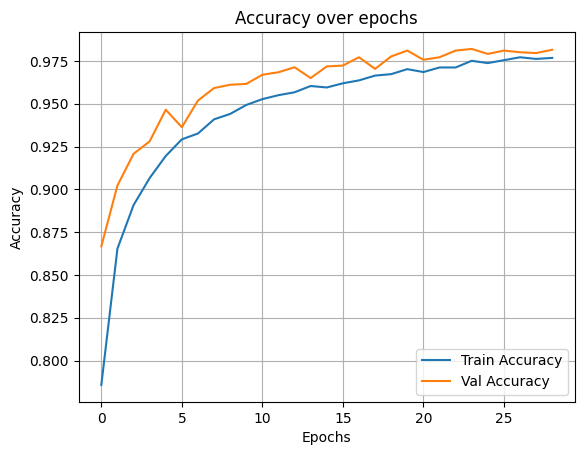

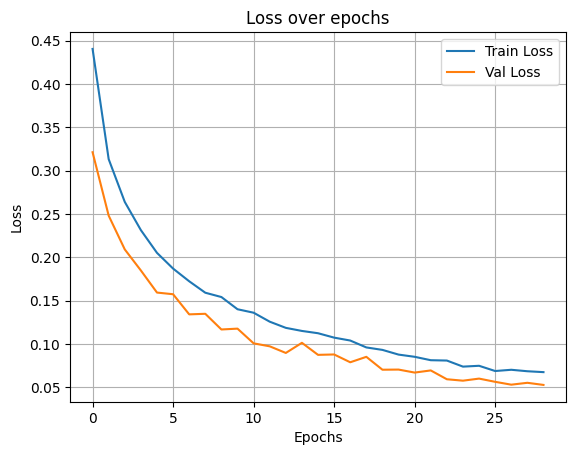

In [49]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 3.5.2 VGG16 Model Confusion Matrix

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_vgg16_model.h5")

65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step


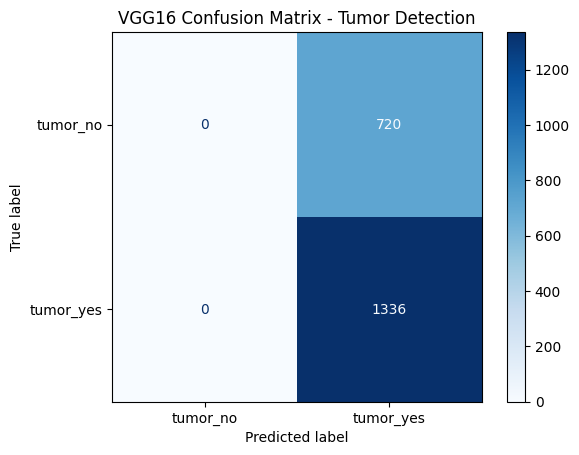

VGG16 Classification Report:

              precision    recall  f1-score   support

    tumor_no       0.00      0.00      0.00       720
   tumor_yes       0.65      1.00      0.79      1336

    accuracy                           0.65      2056
   macro avg       0.32      0.50      0.39      2056
weighted avg       0.42      0.65      0.51      2056



In [73]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("VGG16 Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("VGG16 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))

## 3.6 - EfficientNetB0 - Transfer Learning Model

EfficientNetB0 Transfer Learning was created for another deep learning model.

**EfficientNetB0  - Model Architecture**
*   `base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))` Loads the EfficientNetB0 model pre-trained on ImageNet without the top layer. The input shape is set to 64x64 RGB images.


In [70]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Binary classification output


model_efficientnet = Model(inputs=base_model.input, outputs=x)


for layer in base_model.layers:
    layer.trainable = False

**EfficientNetB0 - Model Compilation**

Adam optimizer was used but early stopping function stopped model training at epoch 6 and Epoch 1 was selected as the best model. Therefore, optimizer function was changed.

*   `learning_rate = 0.0001` learning rate value is decreased to increase learning.

In [61]:
learning_rate = 0.0001  # Learning rate value
optimizer = Adam(learning_rate=learning_rate)


model_efficientnet.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

**EfficientNetB0 - Early Stop**

In [62]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**EfficientNetB0 - Checkpoint**

In [63]:
# Checkpoint
model_checkpoint = ModelCheckpoint(
    'best_efficientnet_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [64]:
model_efficientnet.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 64, 64, 3)      │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 65, 65, 3)      │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 32, 32, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 32, 32, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 32, 32, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 3.7 - EfficientNetB0 - Transfer Learning Model Training

**Model Training - Time Calculation**

In [65]:
import time
start = time.time()

history_efficientnet = model_efficientnet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6368 - loss: 0.6643
Epoch 1: val_accuracy improved from -inf to 0.64981, saving model to best_efficientnet_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 50s 155ms/step - accuracy: 0.6368 - loss: 0.6643 - val_accuracy: 0.6498 - val_loss: 0.6529
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6449 - loss: 0.6559
Epoch 2: val_accuracy did not improve from 0.64981
257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.6449 - loss: 0.6559 - val_accuracy: 0.6498 - val_loss: 0.6466
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6556 - loss: 0.6490
Epoch 3: val_accuracy did not improve from 0.64981
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.6555 - loss: 0.6491 - val_accuracy: 0.6498 - val_loss: 0.6468
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6506 - loss: 0.6510
Epoch 4: val_accuracy did not improve from 0.64981
257/257 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.6506 - loss: 0.6510 - val_accuracy: 0.6498 - val_loss: 0.6475
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6488 - loss: 0.6507
Epoch 5: val_accur

### 3.7.1 - EfficientNetB0 Training Visualization

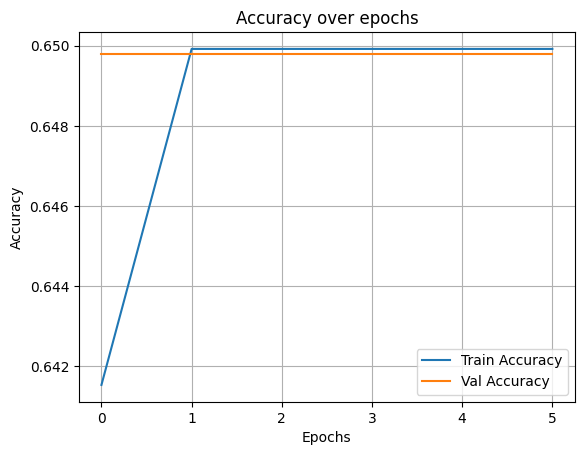

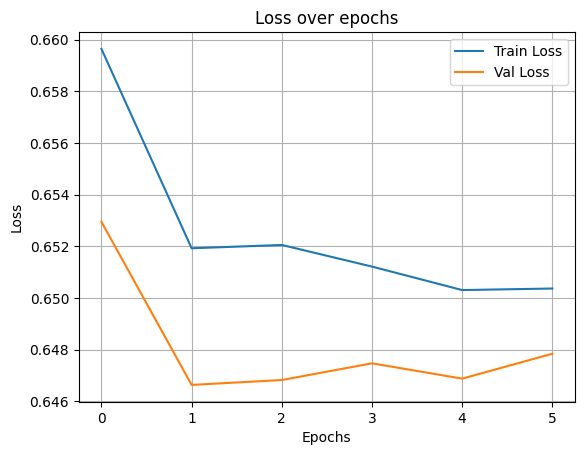

In [66]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 3.7.2 - EfficientNetB0 Confusion Matrix

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_efficientnet_model.h5")

65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step


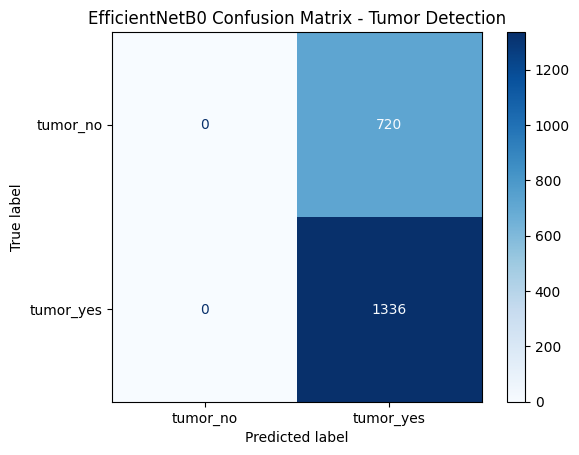

EfficientNetB0 Classification Report:

              precision    recall  f1-score   support

    tumor_no       0.00      0.00      0.00       720
   tumor_yes       0.65      1.00      0.79      1336

    accuracy                           0.65      2056
   macro avg       0.32      0.50      0.39      2056
weighted avg       0.42      0.65      0.51      2056



In [71]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("EfficientNetB0 Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("EfficientNetB0 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))